In [1]:
import numpy as np
import math
from scipy.special import logit, expit
import matplotlib as mpl
import matplotlib.pyplot as plt
import cvxpy as cp
from itertools import combinations
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm

In [2]:
def dce_hat(f_X, Y):
    # Using smCE version of calculating dCE
    n = len(f_X)
    sorted_indices = np.argsort(f_X)
    Y = Y[sorted_indices]
    f_X = f_X[sorted_indices]
    g = cp.Variable(n)
    objective = cp.Maximize(cp.sum(cp.multiply(Y - f_X, g)) / n)
    constraints = [cp.abs(g[i+1] - g[i]) <= cp.abs(f_X[i+1] - f_X[i]) for i in range(n-1)]
    constraints += [g >= -1, g <= 1]
    prob = cp.Problem(objective, constraints)
    sup_val = prob.solve()

    return sup_val

In [3]:
def cutoff_hat(f_X, Y):
    n = len(X)
    sorted_fX = np.sort(f_X)
    supremum = -np.inf
    best_interval = None

    for i, a in enumerate(sorted_fX):
        for b in sorted_fX[i:]:
            mask = (f_X >= a) & (f_X <= b)
            value = np.abs(np.mean((Y - f_X) * mask))

            if value > supremum:
                supremum = value
                best_interval = (a, b)

    return supremum

In [4]:
def ece(f_X_unique, E_Y_f_X_unique):
  return np.mean(np.abs(f_X_unique - E_Y_f_X_unique))

In [5]:
def risk(f_X_unique, E_Y_f_X_unique, tau):
  return tau * np.mean((1-E_Y_f_X_unique) * (f_X_unique >= tau)) + (1-tau) * np.mean(E_Y_f_X_unique * (f_X_unique < tau))

def risk_indicator(indicator_guess, E_Y_f_X_unique, tau):
  return tau * np.mean((1-E_Y_f_X_unique) * indicator_guess) + (1-tau) * np.mean(E_Y_f_X_unique * (1-indicator_guess))

Text(0.5, 1.0, 't = 0.75')

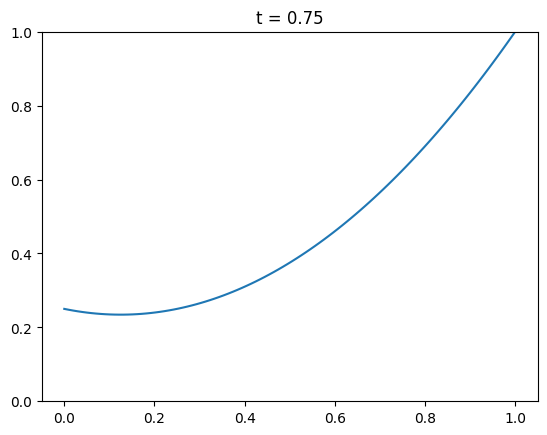

In [6]:
t=0.75
X = np.linspace(0,1, 100)
plt.plot(X, (1-t)*(1 - 4*X + 4 * X**2) + t * (X))
plt.ylim(ymin=0, ymax=1)
plt.title(f't = {t}')

In [7]:


np.random.seed(1)
n = 500
N = 1000
S = 100
tau=0.35

df = pd.DataFrame(columns=['dce','cutoff','ece','dce_hat','cutoff_hat','risk', 'bvce_hat','bvce', 'risk_iso', 'alpha'])

for s in tqdm(range(S)):
  X = np.random.uniform(size=n)
  X_population = np.random.uniform(size=N)

  alpha = np.random.uniform(size=1)

  E_Y_X = alpha*(1 - 4*X + 4 * X**2) + (1-alpha)*X
  E_Y_X_population = alpha*(1 - 4*X_population + 4 * X_population**2) + (1-alpha)*X_population

  Y = np.random.binomial(n=1, p=E_Y_X)
  X_model = sm.add_constant(X)
  X_population_model = sm.add_constant(X_population)
  model = sm.Logit(Y, X_model).fit(disp=0)
  f_X = model.predict(X_model)
  f_X_population = model.predict(X_population_model)

  df.loc[s, 'dce'] = dce_hat(f_X_population, E_Y_X_population)
  df.loc[s, 'cutoff'] = cutoff_hat(f_X_population, E_Y_X_population)
  df.loc[s, 'ece'] = ece(f_X_population, E_Y_X_population)
  df.loc[s, 'risk'] = risk(f_X_population, E_Y_X_population, tau)
  df.loc[s, 'risk_oracle'] = risk(E_Y_X_population, E_Y_X_population, tau)
  df.loc[s, 'risk_iso'] = min(min([risk_indicator(f_X_population>=t, E_Y_X_population, tau) for t in np.sort(np.append(f_X_population, [0,1]))]),
                              min([risk_indicator(f_X_population<=t, E_Y_X_population, tau) for t in np.sort(np.append(f_X_population, [0,1]))]))
  df.loc[s, 'alpha'] = alpha

df['monotone_risk_gap'] = df['risk'] - df['risk_iso']
df['oracle_risk_gap'] = df['risk'] - df['risk_oracle']

100%|██████████| 100/100 [18:45<00:00, 11.25s/it]


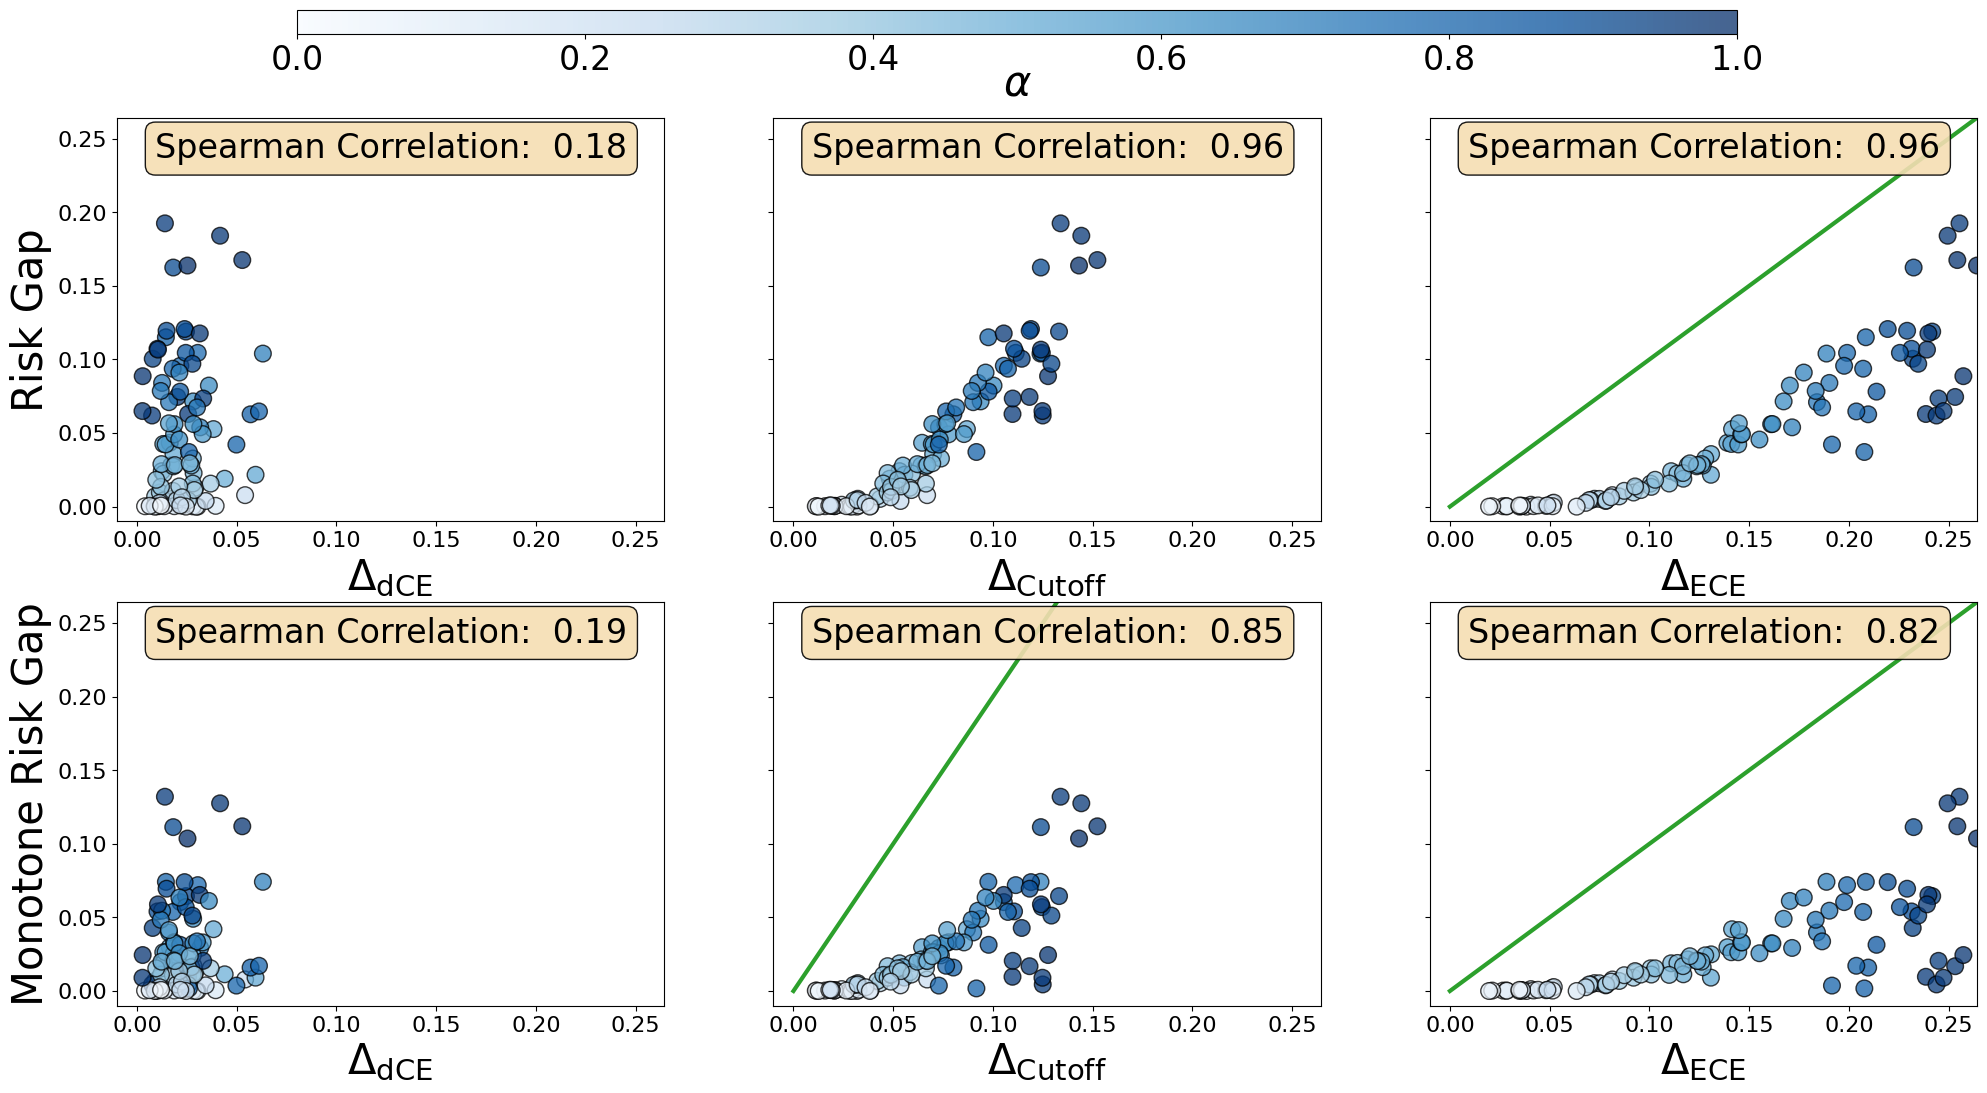

In [8]:

fig, axes = plt.subplots(2, 3, figsize=(24, 12), sharey='all')

x_min = -0.01
x_max = max(df['dce'].max(), df['cutoff'].max(), df['ece'].max())

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)


axes[0, 0].scatter(df['dce'], df['oracle_risk_gap'], c=df['alpha'], cmap='Blues', edgecolor='k', alpha=0.75, s = 4*mpl.rcParams['lines.markersize']**2)
axes[0, 0].set_xlabel(r'$\Delta_\mathrm{dCE}$', fontsize=30)
axes[0, 0].set_ylabel('Risk Gap', fontsize=30)
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].set_ylim(x_min, x_max)
correlation = df.corr(method='spearman').loc['dce','oracle_risk_gap']
axes[0, 0].annotate(f'Spearman Correlation: {correlation: 0.02f}', xy=(0.07, 0.9), xycoords='axes fraction', fontsize=24, bbox=props)

axes[0, 1].scatter(df['cutoff'], df['oracle_risk_gap'], c=df['alpha'], cmap='Blues', edgecolor='k', alpha=0.75, s = 4*mpl.rcParams['lines.markersize']**2)
axes[0, 1].set_xlabel(r'$\Delta_\mathrm{Cutoff}$', fontsize=30)
axes[0, 1].set_xlim(x_min, x_max)
correlation = df.corr(method='spearman').loc['cutoff','oracle_risk_gap']
axes[0, 1].annotate(f'Spearman Correlation: {correlation: 0.02f}', xy=(0.07, 0.9), xycoords='axes fraction', fontsize=24, bbox=props)

axes[0, 2].scatter(df['ece'], df['oracle_risk_gap'], c=df['alpha'], cmap='Blues', edgecolor='k', alpha=0.75, s = 4*mpl.rcParams['lines.markersize']**2)
line_values = np.append(df['ece'].sort_values(ascending=False).values, 0)
axes[0, 2].plot(line_values, line_values, color='tab:green', label='45° line', linewidth=3)
axes[0, 2].set_xlabel(r'$\Delta_\mathrm{ECE}$', fontsize=30)
axes[0, 2].set_xlim(x_min, x_max)
correlation = df.corr(method='spearman').loc['ece','oracle_risk_gap']
axes[0, 2].annotate(f'Spearman Correlation: {correlation: 0.02f}', xy=(0.07, 0.9), xycoords='axes fraction', fontsize=24, bbox=props)

axes[1, 0].scatter(df['dce'], df['monotone_risk_gap'], c=df['alpha'], cmap='Blues', edgecolor='k', alpha=0.75, s = 4*mpl.rcParams['lines.markersize']**2)
axes[1, 0].set_xlabel(r'$\Delta_\mathrm{dCE}$', fontsize=30)
axes[1, 0].set_ylabel('Monotone Risk Gap', fontsize=30)
axes[1, 0].set_xlim(x_min, x_max)
correlation = df.corr(method='spearman').loc['dce','monotone_risk_gap']
axes[1, 0].annotate(f'Spearman Correlation: {correlation: 0.02f}', xy=(0.07, 0.9), xycoords='axes fraction', fontsize=24, bbox=props)

axes[1, 1].scatter(df['cutoff'], df['monotone_risk_gap'], c=df['alpha'], cmap='Blues', edgecolor='k', alpha=0.75, s = 4*mpl.rcParams['lines.markersize']**2)
line_values = np.append(df['cutoff'].sort_values(ascending=False).values, 0)
axes[1, 1].plot(line_values, 2*line_values, color='tab:green', label='45° line', linewidth=3)
axes[1, 1].set_xlabel(r'$\Delta_\mathrm{Cutoff}$', fontsize=30)
axes[1, 1].set_xlim(x_min, x_max)
correlation = df.corr(method='spearman').loc['cutoff','monotone_risk_gap']
axes[1, 1].annotate(f'Spearman Correlation: {correlation: 0.02f}', xy=(0.07, 0.9), xycoords='axes fraction', fontsize=24, bbox=props)

sc = axes[1, 2].scatter(df['ece'], df['monotone_risk_gap'], c=df['alpha'], cmap='Blues', edgecolor='k', alpha=0.75, s = 4*mpl.rcParams['lines.markersize']**2)
line_values = np.append(df['ece'].sort_values(ascending=False).values, 0)
axes[1, 2].plot(line_values, line_values, color='tab:green', label='45° line', linewidth=3)
axes[1, 2].set_xlabel(r'$\Delta_\mathrm{ECE}$', fontsize=30)
axes[1, 2].set_xlim(x_min, x_max)
correlation = df.corr(method='spearman').loc['ece','monotone_risk_gap']
axes[1, 2].annotate(f'Spearman Correlation: {correlation: 0.02f}', xy=(0.07, 0.9), xycoords='axes fraction', fontsize=24, bbox=props)

fig.subplots_adjust(top=0.85)
cbar_ax = fig.add_axes([0.2, 0.92, 0.6, 0.02])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'$\alpha$', fontsize=30, labelpad=-10)
cbar.ax.tick_params(labelsize=24)
sc.set_clim(0, 1)

[t.tick_params(labelsize=16) for t in axes.reshape(-1)]


plt.savefig('simulation_results.pdf', format="pdf", bbox_inches="tight")

plt.show()

# DARKER BLUES CORRESPOND TO LARGER ALPHAS/TS